# Retail Outlet Performance Evaluation

## 1. Business Understanding 

### 1.1 Introduction

The project aims to analyze the sales performance of retail outlets, specifically focusing on the sales data of "Home World," a retailer of building materials. The analysis will cover various aspects, including transaction frequency, daily sales values, customer behavior, and the impact of loyalty programs on sales. By examining these factors, we aim to identify trends, patterns, and insights that can help optimize sales strategies and improve overall performance.

### 1.2 Objectives

1. **Transaction Analysis**: To evaluate the daily transaction frequency and sales values, identifying peak and low periods.
2. **Customer Behavior**: To analyze customer behavior, including new customer acquisition rates and daily customer counts.
3. **Seller Performance**: To assess the performance of different sellers based on transaction counts and sales values.
4. **Loyalty Program Impact**: To investigate the effect of loyalty programs on transaction rates and average sales values.


### 1.3 Methodology

This project will utilize data from December 2016 to February 2017, covering a total of 105,335 transactions. The analysis will involve statistical methods, including Z-test for proportion, to determine the significance of loyalty programs on sales performance.

### 1.4 Data Description

The available dataset contains data about purchases made at a retailer of building materials, "Home World." All customers have a membership card. Note that customers can join the store's loyalty program for $20 per month. This program includes discounts, special offer information, and some rewards.

- **retail_dataset_us.csv** contains:
  - **purchaseID** — Transaction ID in one receipt
  - **item_ID** — Product/Item ID sold by the seller
  - **purchasedate** — Date when the transaction occurred
  - **Quantity** — Number of items in the purchase
  - **CustomerID** — Customer/Patron ID
  - **ShopID** — Seller/Vendor ID
  - **loyalty_program** — Whether the customer is a member of the loyalty program

- **product_codes_us.csv** contains:
  - **price_per_one** — Price of the item per quantity
  - **productID** — Product/Item ID sold by the seller

## 2. Data Mining

In [1]:
#import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# import dataset
price=pd.read_csv('product_codes_us.csv',sep=';')
data=pd.read_csv('retail_dataset_us.csv')

In [3]:
# Combine two dataframes based on the product ID column acting as the primary key
data=pd.merge(data,price,how='left',left_on='item_ID',right_on='productID')
data

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,loyalty_program,ShopID,productID,price_per_one
0,538280,21873,11,2016-12-10 12:50:00,18427.0,0,Shop 3,21873,0.42
1,538862,22195,0,2016-12-14 14:11:00,22389.0,1,Shop 2,22195,1.65
2,538855,21239,7,2016-12-14 13:50:00,22182.0,1,Shop 3,21239,0.72
3,543543,22271,0,2017-02-09 15:33:00,23522.0,1,Shop 28,22271,2.55
4,543812,79321,0,2017-02-13 14:40:00,23151.0,1,Shop 28,79321,0.00
...,...,...,...,...,...,...,...,...,...
105330,538566,21826,1,2016-12-13 11:21:00,NaN,0,Shop 0,21826,1.25
105331,540247,21742,0,2017-01-05 15:56:00,21143.0,0,Shop 24,21742,5.95
105332,538068,85048,1,2016-12-09 14:05:00,23657.0,1,Shop 16,85048,6.95
105333,538207,22818,11,2016-12-10 11:33:00,18427.0,0,Shop 29,22818,0.42


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   Quantity         105335 non-null  int64  
 3   purchasedate     105335 non-null  object 
 4   CustomerID       69125 non-null   float64
 5   loyalty_program  105335 non-null  int64  
 6   ShopID           105335 non-null  object 
 7   productID        105335 non-null  object 
 8   price_per_one    105335 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 7.2+ MB


## 3. Preprocessing

### 3.1 Data Cleaning

In [5]:
# Check for duplicate data
print('Data Duplicate :', data.duplicated().sum())

if data.duplicated().sum()>0:
    data.drop_duplicates(inplace=True)
    print('After Drop Duplicated :', data.duplicated().sum())

Data Duplicate : 1033
After Drop Duplicated : 0


In [6]:
# Check for null or NaN values
data.isnull().sum()

purchaseid             0
item_ID                0
Quantity               0
purchasedate           0
CustomerID         36148
loyalty_program        0
ShopID                 0
productID              0
price_per_one          0
dtype: int64

In [7]:
# Check the percentage of null values in the entire dataset
print(round(data[data.CustomerID.isnull()].shape[0]/data.shape[0]*100,2),'%')

34.66 %


### 3.2 Data Manipulation

In [8]:
# Generate random user IDs for null transaction IDs
import random
randomList=[]
while len(randomList) < data[data.CustomerID.isnull()].purchaseid.nunique():
    # Ensure the range of values is 4 digits to avoid matching existing user IDs
    r=random.randint(1000,9999)
    # Prevent ID duplication by ensuring unique creation
    if r not in randomList:
        randomList.append(r)

In [9]:
# Fill null values with randomly generated user IDs
purchase=data[data.purchaseid.isin(data[data.CustomerID.isnull()].purchaseid.unique())].purchaseid.unique()
for x in range(len(randomList)):
    data.loc[data.purchaseid==purchase[x], 'CustomerID'] = randomList[x]

In [10]:
# Check the minimum and maximum quantity values
data[data.Quantity<0].sort_values('Quantity')

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,loyalty_program,ShopID,productID,price_per_one
49411,C541433,23166,-74216,2017-01-18 10:17:00,18025.0,0,Shop 21,23166,1.04
39345,C536757,84347,-9361,2016-12-02 14:23:00,21517.0,0,Shop 17,84347,0.03
104960,540564,22617,-2601,2017-01-10 10:36:00,1985.0,0,Shop 0,22617,0.00
10687,543257,84611B,-1431,2017-02-04 16:06:00,3246.0,0,Shop 0,84611B,0.00
53844,541685,22351,-1401,2017-01-20 15:41:00,2213.0,0,Shop 0,22351,0.00
...,...,...,...,...,...,...,...,...,...
59854,C538692,22801,-2,2016-12-14 09:58:00,19278.0,0,Shop 23,22801,3.39
59788,C540793,POST,-2,2017-01-11 11:53:00,19974.0,0,Shop 2,POST,0.00
59721,C543608,82483,-2,2017-02-10 14:15:00,22909.0,1,Shop 23,82483,4.95
60103,C540950,22960,-2,2017-01-12 12:51:00,23905.0,1,Shop 27,22960,3.75


In [11]:
# Check for zero or negative values in the 'Quantity' column
data[data.Quantity<=0].shape[0]

34438

In [12]:
# Check for zero or negative values in the 'price_per_one' column
data[data.price_per_one<=0].shape[0]

16496

In [13]:
# Create a column for total transaction values
data['price_total']=data.Quantity*data.price_per_one

In [14]:
# Convert columns with specific data types
data.purchasedate = pd.to_datetime(data.purchasedate)
data.sort_values('purchasedate',inplace=True)
data['purchasedate']=data.purchasedate.dt.date
data.purchasedate = pd.to_datetime(data.purchasedate, format='%Y-%m-%d')

In [15]:
# Check for the oldest and most recent transactions
print("Minimum date: {}, Maximum date: {}".format(data["purchasedate"].min(),data["purchasedate"].max()))

Minimum date: 2016-12-01 00:00:00, Maximum date: 2017-02-28 00:00:00


## 4. Exploratory Data Anaylsis

### Generate Function

In [16]:
def daily(data,label):
    data=data.groupby([pd.Grouper(key='purchasedate',freq='d')]).aggregate('sum').reset_index()
    data=data[data[label]!=0]
    plt.figure(figsize=(10,3))
    plt.bar(data=data,x='purchasedate',height=label)
    print('Daily Average :', data[label].mean())
    display(pd.concat([data.nlargest(n=1,columns=[label]),data.nsmallest(n=1, columns=[label])]))

In [17]:
def amount(data,x,y):
    plt.figure(figsize=(10,4))
    amount=data.groupby(x)[y].sum().sort_values(ascending=False).iloc[:5].reset_index()
    sns.barplot(data=amount, x=x, y=y,order=amount[x].value_counts().index)
    x=amount[x]
    y=amount[y]
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

### 4.1 Transaction Analysis

#### 4.1.1 Daily Transactions Amount

In [18]:
# Create a chart showing the number of transactions in one day
data_transaction=data.groupby(['purchasedate']).size().reset_index(name='transaction')

# Display daily data when there were no transactions at all
daily_closed=data_transaction.groupby([pd.Grouper(key='purchasedate',
                                                  freq='d')]).aggregate('sum').reset_index()
daily_closed['day'] = daily_closed['purchasedate'].dt.day_name()
daily_closed[daily_closed.transaction==0]

,purchasedate,transaction,day
3,2016-12-04,0,Sunday
10,2016-12-11,0,Sunday
17,2016-12-18,0,Sunday
23,2016-12-24,0,Saturday
24,2016-12-25,0,Sunday
25,2016-12-26,0,Monday
26,2016-12-27,0,Tuesday
27,2016-12-28,0,Wednesday
28,2016-12-29,0,Thursday
29,2016-12-30,0,Friday


Based on the data above, it can be seen that the "Home World" building materials retailer is closed every Sunday. Additionally, no transactions occurred over the 11-day period from December 24, 2016, to January 3, 2017. This is likely due to the store being closed for Christmas and New Year's holidays, resulting in no transactions during that time.

Thus, in the next daily transaction exploration, the data will not include store holidays, only the days when the store operates.

Daily Average : 1533.8529411764705


,purchasedate,transaction
5,2016-12-06,3830
67,2017-02-06,273


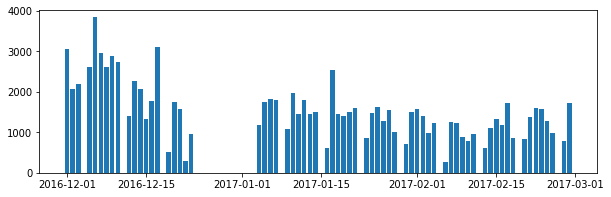

In [19]:
# Visualization of the daily data distribution
daily(data_transaction,'transaction')

On average, there are 1533 transactions per purchase (purchase ID) each day. The highest daily transaction peak per purchase occurred on December 6, 2016, with a total of 3830 transactions. The lowest daily transaction count per purchase occurred on February 6, 2017, with a total of 273 transactions.

#### 4.1.2 Daily Transactions Value

Daily Average : 15940.170588235296


,purchasedate,price_total
48,2017-01-18,85314.88
67,2017-02-06,1888.13


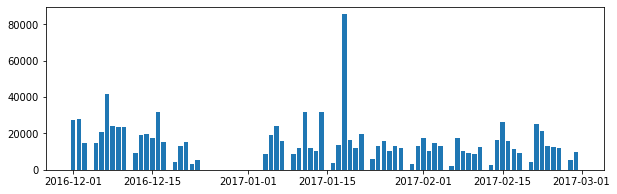

In [20]:
# Create a chart showing the total transaction value in one day
data_price=data[data.price_total>0].groupby('purchasedate')['price_total'].sum().reset_index()
daily(data_price,'price_total')

The average daily transaction value is 15940. The highest daily transaction value occurred on January 18, 2017, amounting to 85314, while the lowest daily transaction value occurred on June 22, 2017, with a value of 1888.

#### 4.1.3 Weekly Transaction Trends

       weekly  transaction rate_transaction  price_total rate_price
0  2016-11-27         7315            nan %     70190.41      nan %
1  2016-12-04        17601         140.62 %    148825.08   112.03 %
2  2016-12-11        11951          -32.1 %    112826.47   -24.19 %
3  2016-12-18         5088         -57.43 %     41191.22   -63.49 %
4  2016-12-25            0         -100.0 %         0.00   -100.0 %
5  2017-01-01         6539            inf %     67605.06      inf %
6  2017-01-08         9261          41.63 %    106430.60    57.43 %
7  2017-01-15         9082          -1.93 %    151168.48    42.03 %
8  2017-01-22         7804         -14.07 %     69797.13   -53.83 %
9  2017-01-29         7374          -5.51 %     70984.71      1.7 %
10 2017-02-05         5354         -27.39 %     60430.97   -14.87 %
11 2017-02-12         6785          26.73 %     81803.16    35.37 %
12 2017-02-19         7644          12.66 %     87720.73     7.23 %
13 2017-02-26         2504         -67.24 %     

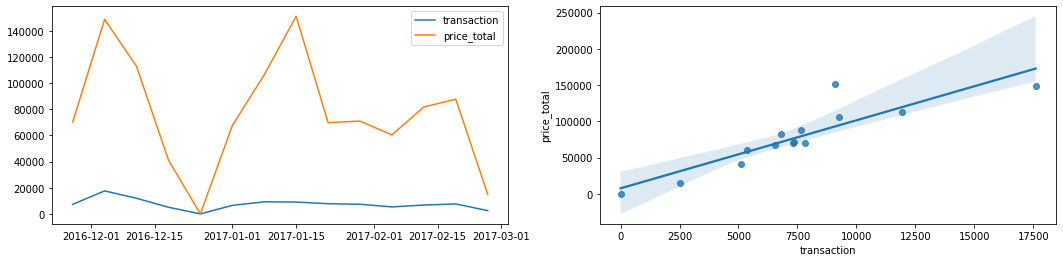

In [21]:
# Create a percentage increase in the number of weekly transactions
data_transaction['weekly']=pd.to_datetime(data_transaction['purchasedate']) - pd.to_timedelta(7, unit='d')
data_weekly1=data_transaction.iloc[:,1:].groupby([pd.Grouper(key='weekly',freq='W')]).aggregate('sum').reset_index()
data_weekly1['rate_transaction']=data_weekly1.diff().transaction/data_weekly1.transaction.shift(1)*100
data_weekly1['rate_transaction']=data_weekly1['rate_transaction'].round(2).astype(str)+str(' %')

# Create a percentage increase in the value of weekly transactions
data_price['weekly']=pd.to_datetime(data_price['purchasedate']) - pd.to_timedelta(7, unit='d')
data_weekly2=data_price.iloc[:,1:].groupby([pd.Grouper(key='weekly',freq='W')]).aggregate('sum').reset_index()
data_weekly2['rate_price']=data_weekly2.diff().price_total/data_weekly2.price_total.shift(1)*100
data_weekly2['rate_price']=data_weekly2['rate_price'].round(2).astype(str)+str(' %')

# Merge the two dataframes that have been created
data_weekly=pd.merge(data_weekly1,data_weekly2)
plt.figure(figsize=(18,4))
plt.subplot(1,2,1)
plt.plot(data_weekly[['weekly','transaction']].set_index('weekly'),label='transaction')
plt.plot(data_weekly[['weekly','price_total']].set_index('weekly'),label='price_total')
plt.legend()
plt.subplot(1,2,2)
sns.regplot(data=data_weekly,x='transaction',y='price_total')
print(data_weekly)

In [22]:
data_weekly

,weekly,transaction,rate_transaction,price_total,rate_price
0,2016-11-27,7315,nan %,70190.41,nan %
1,2016-12-04,17601,140.62 %,148825.08,112.03 %
2,2016-12-11,11951,-32.1 %,112826.47,-24.19 %
3,2016-12-18,5088,-57.43 %,41191.22,-63.49 %
4,2016-12-25,0,-100.0 %,0.00,-100.0 %
5,2017-01-01,6539,inf %,67605.06,inf %
6,2017-01-08,9261,41.63 %,106430.60,57.43 %
7,2017-01-15,9082,-1.93 %,151168.48,42.03 %
8,2017-01-22,7804,-14.07 %,69797.13,-53.83 %
9,2017-01-29,7374,-5.51 %,70984.71,1.7 %


Based on the scatterplot above, the number of transactions and the value of weekly transactions are positively correlated. The higher the number of transactions, the higher the transaction value generated. From the dataframe above, the highest weekly percentage increase occurred between the first and second weeks, with an increase of over 100%. Meanwhile, the lowest weekly percentage occurred between the 13th and 14th weeks, with a decrease of over 60% (exception of the 5th week there is a Christmas and New Year holiday).

#### 4.1.4 Monthly Transaction Trends

,purchasedate,month,transaction,rate_transaction,price_total,rate_price
0,2016-12-31,December,41955,nan %,373033.18,nan %
1,2017-01-31,January,34895,-16.83 %,410839.72,10.13 %
2,2017-02-28,February,27452,-21.33 %,300058.70,-26.96 %


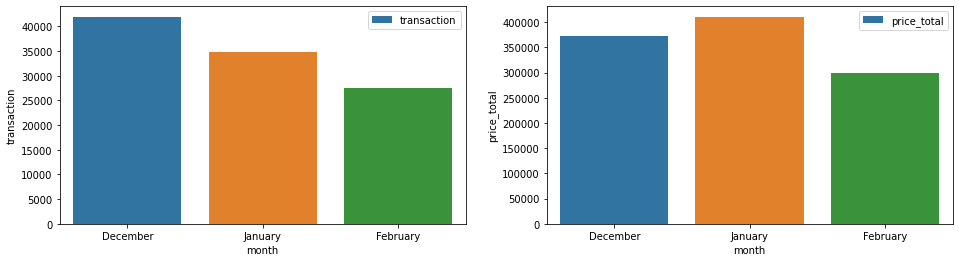

In [23]:
# Create a percentage increase in the number of monthly transactions
data_monthly1=data_transaction.iloc[:,:-1].groupby([pd.Grouper(key='purchasedate',freq='M')]).aggregate('sum').reset_index()
data_monthly1['rate_transaction']=data_monthly1.diff().transaction/data_monthly1.transaction.shift(1)*100
data_monthly1['rate_transaction']=data_monthly1['rate_transaction'].round(2).astype(str)+str(' %')

# Create a percentage increase in the value of monthly transactions
data_monthly2=data_price.iloc[:,:-1].groupby([pd.Grouper(key='purchasedate',freq='M')]).aggregate('sum').reset_index()
data_monthly2['rate_price']=data_monthly2.diff().price_total/data_monthly2.price_total.shift(1)*100
data_monthly2['rate_price']=data_monthly2['rate_price'].round(2).astype(str)+str(' %')

# Merge the two dataframes that have been created
data_monthly=pd.merge(data_monthly1,data_monthly2)
data_monthly['month']=data_monthly['purchasedate'].dt.month_name()
display(data_monthly.iloc[:,[0,-1,1,2,3,4]])

plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.barplot(data=data_monthly,x='month',y='transaction',label='transaction')
plt.legend()

plt.subplot(1,2,2)
sns.barplot(data=data_monthly,x='month',y='price_total',label='price_total')
plt.legend()

Based on the monthly data, it can be seen that the number of transactions and the value of transactions consistently decreased. December had the highest number of transactions and transaction value compared to January and February. Even though 11 days in December were closed due to Christmas and New Year's holidays, it still had the most significant figures.

The largest drop in transaction volume occurred from January to February, with a -21% decrease. Meanwhile, the largest decline in transaction value occurred from December to January, with an -11% drop.

### 4.2 Customer Analysis

#### 4.2.1 Daily Active Customers

Daily Average : 63.9264705882353


,purchasedate,customer
8,2016-12-09,173
67,2017-02-06,11


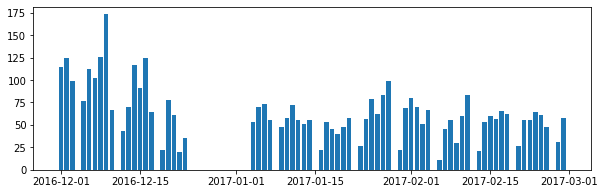

In [24]:
# Create a chart showing the number of customers who made transactions in one day
data_customer=data.groupby('purchasedate').CustomerID.nunique().reset_index(name='customer')

# Visualization of the daily data distribution
daily(data_customer,'customer')

On average, 64 customers made transactions per day. The highest daily number of customers occurred on December 9, 2016, with 173 people. The lowest daily customer count occurred on February 6, 2017, with 11 people.

#### 4.2.2 Daily New Customers

Daily Average : 36.720588235294116


,purchasedate,new_customer
8,2016-12-09,134
67,2017-02-06,4


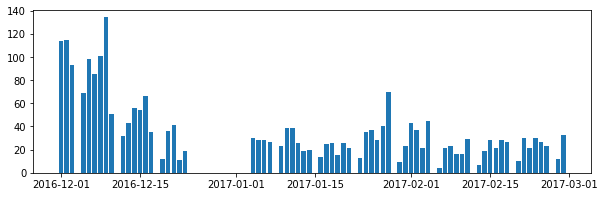

In [25]:
# Create a chart showing the number of customers making their first transaction each day
data_new = data.sort_values('purchasedate').groupby('CustomerID').first()
data_new = data_new.groupby(['purchasedate']).size().reset_index(name='new_customer')

# Visualization of the daily data distribution
daily(data_new,'new_customer')

On average, 36 new users make their first purchase each day. The peak of daily new user transactions occurred on December 9, 2016, with 134 users, while the lowest new user count occurred on February 6, 2017, with 4 users.

#### 4.2.3 Customers Transaction Distribution

Text(0.5, 1.0, 'Histogram Jumlah Transaksi per Customer')

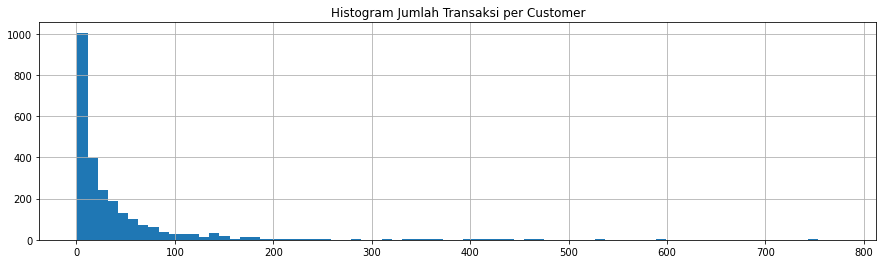

In [26]:
# Create a histogram showing the number of purchases per customer
plt.figure(figsize=(15,4))
data.CustomerID.value_counts().hist(bins=75)
plt.title('Histogram Jumlah Transaksi per Customer')

The data distribution in each group is divided into ranges of 10 transactions, as follows:
1. Most customers have made between 0 and 10 purchases, with around 1000 people in this range.
2. The second-largest group is customers who made between 11 and 20 purchases, with around 400 people.
3. More than 200 people made between 21 and 30 purchases.
4. As the transaction count increases, the number of customers in each group tends to decrease

#### 4.2.4 Top Performing Customers Transaction

In [27]:
data.groupby('CustomerID').size().sort_values().reset_index()[-5:]

,CustomerID,0
2492,4403.0,675
2493,20990.0,715
2494,20285.0,745
2495,23520.0,751
2496,18427.0,774


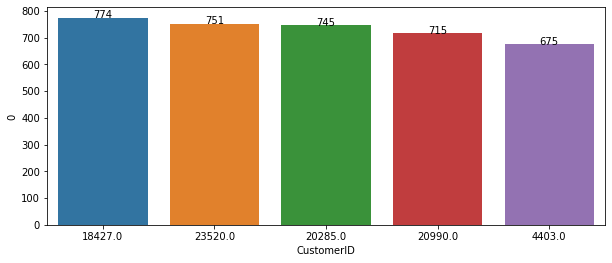

In [28]:
# List of the 5 customers with the most transactions
amount(data.groupby('CustomerID').size().sort_values().reset_index()[-5:],x='CustomerID',y=0)

The diagram above shows the top 5 customers based on the number of transactions they have made. The customer with ID '18427' ranks first, having made 774 transactions. Only 4 customers have made more than 700 transactions

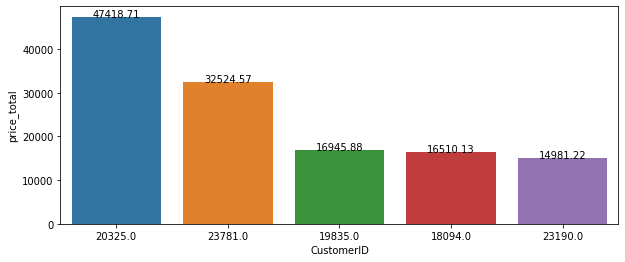

In [29]:
# List of the 5 customers with the highest transaction value
amount(data,x='CustomerID',y='price_total')

The graph above shows the top 5 customers with the highest transaction values based on the total amount spent.

### 4.3 Seller Analysis

#### 4.3.1 Top Sellers by Transaction Share:

<AxesSubplot:>

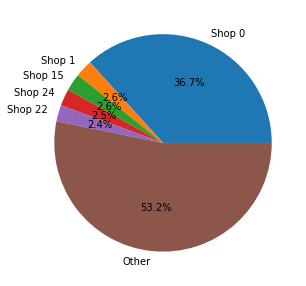

In [30]:
# Create a pie chart showing the percentage of purchases at various stores
other=data.ShopID.value_counts().sort_values(ascending=False).reset_index()[5:]['count'].sum()
other=pd.Series({'Other':other})
top5=data.ShopID.value_counts().sort_values(ascending=False).head(5)
plt.figure(figsize=(5,5))
pd.concat([top5,other]).plot.pie(autopct='%0.1f%%')

In [31]:
# Table of sellers with the most transactions
pd.concat([top5,other]).reset_index()

,index,0
0,Shop 0,38303
1,Shop 1,2689
2,Shop 15,2679
3,Shop 24,2624
4,Shop 22,2538
5,Other,55469


Based on the seller percentage of transactions:
1. The seller with ID 'Shop 0' accounts for the most significant percentage, with 37.72% of transactions.
2. Both 'Seller 1' and 'Seller 15' share the second-highest percentage, each with 2.6% of transactions.
3. They are followed by 'Seller 24' and 'Seller 22', with percentages of 2.5% and 2.4%, respectively.
4. The rest of the top 6 sellers are grouped under the label 'Other', contributing a combined 53.2%.

There is a vast disparity in the number of transactions between 'Shop 0' and other sellers. In fact, the number of transactions at 'Shop 0' is 14 times higher than the seller in second place.

#### 4.3.2 Top Sellers by Transaction Value:

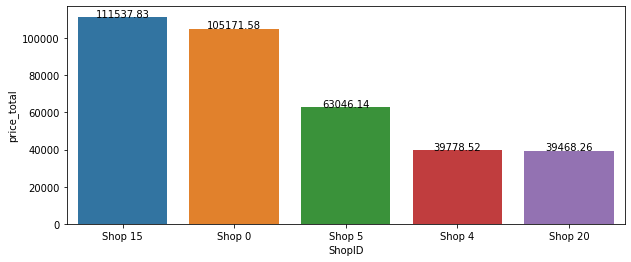

In [32]:
# List of the 5 sellers with the highest transaction value
amount(data,'ShopID',y='price_total')

The graph above shows the top 5 sellers based on transaction value, based on the total value of goods sold. 'Shop 15' ranks first, with a value exceeding 111 thousand, even though the number of transactions is 14 times smaller than that of 'Shop 0'.

### 4.4 Purchase Analysis per Receipt

In [33]:
# Calculate the number of transactions per purchase
print('Average transactions per receipt \t\t:', data.groupby('purchaseid').size().mean())
print('Highest number of transactions in one receipt\t:', data.groupby('purchaseid').size().max())

print('\nAverage transaction value per receipt \t\t:', data.groupby('purchaseid')['price_total'].sum().mean())
print('Highest transaction value in one receipt \t:', data.groupby('purchaseid')['price_total'].sum().max())

Average transactions per receipt 		: 21.312219043727012
Highest number of transactions in one receipt	: 675

Average transaction value per receipt 		: 199.31468328565592
Highest transaction value in one receipt 	: 77182.56


On average, there are 21 items purchased per receipt (purchase ID), with the highest number of items bought being 675 in a one receipt. The average transaction value per receipt is 199, with the highest transaction value in one receipt being 77182.



### 4.5 Loyalty Program Analysis

In [34]:
# Clean data that does not have a valid customer ID
data_clean=data[(data.CustomerID.astype(str).str.len()==7)&(data.price_total>0)]
data_clean1=data[data.CustomerID.astype(str).str.len()==7]
data_clean2=data[data.price_total>=0]

To analyze the transaction rate per customer, the data must first be cleaned by dropping entries that do not have a valid customer ID. In the previous preprocessing step, it was established that data with an invalid customer ID has a string length of 6 digits, so the data to be used will have customer IDs of 7 digits in length.

In [35]:
a=data_clean1.groupby('loyalty_program')['CustomerID'].nunique()
b=data_clean1.loyalty_program.value_counts()
c=data_clean1.groupby('loyalty_program')['purchaseid'].nunique()

In [36]:
# The number of transactions per customer based on their loyalty program
data1=pd.concat([a,b,(b/a).round(2)],axis=1).rename(columns={'loyalty_program':'counts',0:'rate'})
data1=data1.reset_index().rename(columns={'index':'loyalty_program'})
data1

,loyalty_program,CustomerID,count,rate
0,0,1162,44742,38.50
1,1,587,23412,39.88


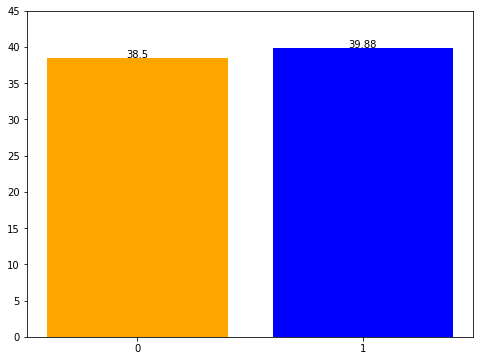

In [37]:
# Tampilkan conversion rate masing-masing kelompok dalam grafik 
plt.figure(figsize=(8,6))
x0=data1.iloc[0,2]
n0=data1.iloc[0,1]
x1=data1.iloc[1,2]
n1=data1.iloc[1,1]
x=['0','1']
y=[x0/n0,x1/n1]
y=list(np.around(np.array(np.array(y)),2))
plt.bar(x=x,height=y,color=['orange','blue'])
plt.ylim(0,45)
for i in range(len(x)):
    plt.text(i, y[i], s=f'{y[i]}', ha = 'center')

Based on the data above, customers in the loyalty program have a higher transaction rate than non-loyalty customers. On average, a loyalty program customer makes 39.88 transactions, higher than the 38.5 transactions per non-loyalty customer.

In [38]:
# View the average transaction value
data2=data_clean2.groupby('loyalty_program')[['Quantity','price_per_one','price_total',]].mean().reset_index()
data2

,loyalty_program,Quantity,price_per_one,price_total
0,0,8.604314,2.021320,10.213431
1,1,10.077757,2.096444,11.666697


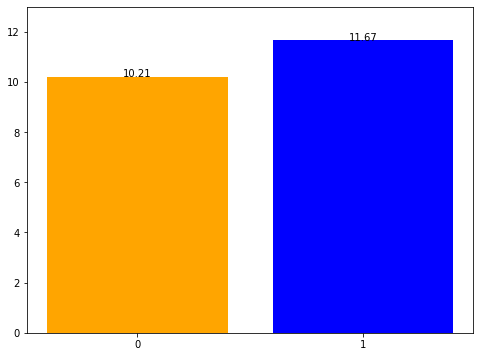

In [39]:
# Show the conversion rate for each group in a chart
plt.figure(figsize=(8,6))
x=['0','1']
y=[data2.iloc[0,3],data2.iloc[1,3]]
y=list(np.around(np.array(np.array(y)),2))
plt.bar(x=x,height=y,color=['orange','blue'])
plt.ylim(0,13)
for i in range(len(x)):
    plt.text(i, y[i], s=f'{y[i]}', ha = 'center')

According to the data, the average transaction value (quantity, total price, and price per item) for loyalty program customers is higher than for non-loyalty program customers.

## 5. Hypothesis Testing

Z-test hypothesis testing is a crucial step to see whether the loyalty program has any effect on purchase transactions. Although previous analyses concluded that transactions made by customers in the loyalty program had higher quantities and values compared to non-loyalty program customers, it is necessary to confirm that this is not due to coincidence. This can be determined using a Z-test for proportions.

To calculate the proportion in the Z-test, the data is divided into two groups: loyalty and non-loyalty. A threshold is set, representing the average number of transactions and transaction values made by each customer. Then, the proportion of each group is determined by comparing how many customers have made transactions exceeding the threshold relative to the total number of customers in their group. The proportion comparison will serve as the conversion rate for each group.

The hypothesis criteria are as follows:
1. Null Hypothesis (H0): The loyalty program does not affect the conversion rate.
2. Alternative Hypothesis (Ha): The loyalty program does affect the conversion rate.

In [40]:
# Determine the threshold for the average number of transactions per customer
threshold1=data_clean1.CustomerID.value_counts().mean()

# Determine the proportion value for each group for the number of transactions per customer
non_member=data_clean1[data_clean1.loyalty_program==0]
user_non=non_member.CustomerID.value_counts().reset_index()
x0=user_non[user_non['count']>=threshold1].shape[0]
n0=user_non.shape[0]

member=data_clean1[data_clean1.loyalty_program==1]
user_member=member.CustomerID.value_counts().reset_index()
x1=user_member[user_member['count']>=threshold1].shape[0]
n1=user_member.shape[0]

pd.DataFrame({'loyalty_program':['No','Yes'],'n_threshold':[x0,x1],'n_customer':[n0,n1],'conversion_rate':[x0/n0,x1/n1]})

,loyalty_program,n_threshold,n_customer,conversion_rate
0,No,344,1162,0.296041
1,Yes,208,587,0.354344


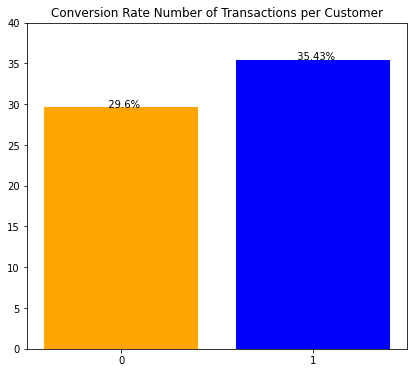

In [41]:
# Display the conversion rate of each group in a chart 
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title('Conversion Rate Number of Transactions per Customer')
x=['0','1']
y=[x0/n0,x1/n1]
y=list(np.around(np.array(np.array(y)*100),2))
plt.bar(x=x,height=y,color=['orange','blue'])
plt.ylim(0,40)
for i in range(len(x)):
    plt.text(i, y[i], s=f'  {y[i]}%', ha = 'center')

Even though the conversion rate shows that the loyalty program can increase the average number of transactions per customer, a hypothesis test is still needed to determine whether the loyalty program has a significant impact or if it is just by chance. Therefore, the new recommendation system as a strategy to increase purchase transactions needs to be tested using a Z-test.

The result of the Z-test will determine which hypothesis will be accepted, with the p-value interpretation as follows:
1. P-value > 0.05 : Accept H0 and reject Ha. This means that the new recommendation system does not have an effect, and the higher conversion rate is due to chance.
2. P-value <= 0.05 : Accept Ha and reject H0. This means that the new recommendation system has an effect, and the higher conversion rate is not due to chance.

In [42]:
# Do a Z-test for proportion to get the p-value
count = np.array([x0,x1])
nobs = np.array([n0,n1])
z,p = proportions_ztest(count, nobs, value=0, alternative='two-sided')
print('z-stat = {z} \np-value = {p}'.format(z=z,p=p))

z-stat = -2.4773645922819236 
p-value = 0.013235662053565115


Based on the Z-test result, with a p-value < 0.05, Ha is accepted, and H0 is rejected. This means that the loyalty program does indeed affect the number of transactions per customer. The higher number of transactions among loyalty program members compared to non-loyalty program customers is not coincidental. Therefore, the loyalty program contributes to an increase in the number of transactions at the store.

## 6. General Conclusion

Based on the exploration, analysis, and hypothesis testing conducted, several conclusions can be drawn:

1. In addition to the weekends (Saturday and Sunday), the store was also closed for 11 days due to Christmas and New Year's holidays.
2. December 9, 2016, and February 6, 2017, were the busiest and quietest days, respectively, in terms of customers making transactions and new customers making their first purchase.
3. Shop 0 emerged as a "superpower" seller in terms of the number of transactions. Shop 0 had 14 times more transactions than the seller in second place
4. The number of transactions and transaction values at the store have been steadily decreasing month by month.
5. The Z-test for proportions showed that the loyalty program has a significant impact on the number of transactions per customer.

## 7. Suggestions

Since the loyalty program has been proven to increase the number of transactions per customer, it is recommended to further develop this program, such as by offering more events or special promotions for loyalty program customers. Reducing the loyalty program fee from $20 could also be considered to attract more customers to join the program